## Aim 1 - Recreate Figure 2 from Alleman et al

Figure 2 from [Alleman et al](pmc.ncbi.nlm.nih.gov/articles/PMC8686835/) shows experimental vs predicted growth rate of _Azobacter vinelandii_ under different oxygen concentrations and sucrose uptake rates. Panel a shows the predicted rates when using the partially-coupled branch of the electron transport system for ATPM flux determination, and panel b shows the rates under the fully-coupled branch.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import cobra

In [2]:
# load data (downloaded from Alleman et al)
table_s2 = pd.read_excel('./data/alleman_table_s2.xlsx', index_col=0)
original_model = cobra.io.load_json_model('./data/iAA1300.json')
original_model_c = cobra.io.load_json_model('./data/iAA1300_C.json')  # C for carbon limited (used for ATPM maintenance predictions)
model = original_model_c.copy()

In [3]:
# view data format
table_s2.head()

,Sucrose_uptake_gcdw,O2_conc,ATPM_pred,ETS_path,Growth_rate_exp,Growth_rate_pred,Oxygen_consumption_pred,ATP_production,ATPM_ATP_prect,growth_yeild_suc_pred,growth_yeild_suc_exp,growth_yeild_o2_pred,growth_yeild_o2_exp
0,2.01,12,16.258129,NII_BD_F,0.06,0.094395,19.432741,39.352471,0.413141,46.962927,29.850746,4.857549,3.087573
1,2.24,12,16.258129,NII_BD_F,0.07,0.112532,21.292168,43.321077,0.375294,50.237446,31.250000,5.285130,3.287594
2,2.24,12,16.258129,NII_BD_F,0.10,0.112532,21.292168,43.321077,0.375294,50.237446,44.642857,5.285130,4.696563
3,2.40,12,16.258129,NII_BD_F,0.12,0.125149,22.585683,45.671348,0.355981,52.145209,50.000000,5.541055,5.313100
4,3.79,12,16.258129,NII_BD_F,0.18,0.234755,33.823092,69.296014,0.234619,61.940741,47.493404,6.940684,5.321808


In [4]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.004845,0,0.00%
cl_e,EX_cl_e,0.004845,0,0.00%
cobalt2_e,EX_cobalt2_e,2.327E-05,0,0.00%
cu2_e,EX_cu2_e,0.00066,0,0.00%
fe2_e,EX_fe2_e,0.007682,0,0.00%
fe3_e,EX_fe3_e,0.007268,0,0.00%
glc__D_e,EX_glc__D_e,15,6,100.00%
h_e,EX_h_e,1.161,0,0.00%
k_e,EX_k_e,0.1817,0,0.00%
mg2_e,EX_mg2_e,0.008075,0,0.00%


In [5]:
# define the partial and full pathways as well as what reactions should be knocked out for each one.
paths = ['NII_BD_R', 'NI_CO_R']
kos = [['NADH6', 'CYOO2pp', 'FIX'], ['NADH5', 'CYTBDpp', 'FIX']]
couplings = ['partial', 'full']

In [6]:
# Taken from Kuhla et al - https://doi.org/10.1007/BF00446753
maintenance_coeffs = [0.9, 4.4, 6.2, 7, 8]   # amount of sucrose used for maintenance in each o2 concentration
o2_concs = [12, 48, 108, 144, 192]

### Calculating ATPM flux

ETS_path column is described [here](http://github.com/alexander-alleman/Azotobactervinelandii_metabolicmodel/blob/main/Notebooks/ETS_Maintenance_Energy.ipynb).

ATPM flux will be calculated via methodology described in the paper.
> ATP maintenance rate was determined by setting substrate uptake rate to the maintenance coefficient and increasing ATP maintenance reaction flux until growth rate reached zero.

> ...to determine the value of NGAM, the ATPM rate lower bound was increased until the growth reached zero, allowing all sucrose consumption to be allocated to NGAM... A specific ATPM flux was determined for each ETS branch under different O2 concentrations using the experimentally determined maintenance coefficient.

In [7]:
# Calculate the minimum ATPM flux for each pathway, looking for the highest value of ATPM that 
# produces minimal growth when given the maintenance amount of sucrose for each o2 concentration.
atpm_dict = {}
for path, reacs, coupled in zip(paths, kos, couplings):
  model = original_model_c.copy()
  model.reactions.EX_glc__D_e.bounds = [0, 0]
  model.reactions.EX_nh4_e.bounds = [0, 0]
  for reac in reacs:
    model.reactions.get_by_id(reac).bounds = [0, 0]

  for o2_conc, maint in zip(o2_concs, maintenance_coeffs):
    model.reactions.EX_sucr_e.bounds = [-maint, -maint]

    # binary search atpm val
    low = 0
    high = 1000
    while True:
      mid = (low + high) / 2
      model.reactions.ATPM.bounds = [mid, 1000]
      res = model.optimize()
      if res.status == 'optimal':
        if res.objective_value < 0.00001:  # very small growth, but feasible
          atpm_dict[(coupled, o2_conc)] = res.fluxes['ATPM']
          break
        else:  # more growth than desired, increase maintenance
          low = mid
      else:  # not feasible, decrease maintenance
        high = mid
  

/usr3/graduate/dcscott/.local/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [13]:
# Save to a file, and print so we can compare to paper predictions
atpm_vals = pd.Series(atpm_dict)
atpm_vals.to_csv('./data/atpm.csv')
atpm_vals

partial  12      16.075134
         48      78.598022
         108    110.752106
         144    125.043869
         192    142.908096
full     12      50.231934
         48     245.597839
         108    346.069336
         144    390.724182
         192    446.544647
dtype: float64

In [14]:
# Check that our predictions closely match the predictions made in the paper
paper_preds = table_s2.groupby(['ETS_path', 'O2_conc'], as_index=False).aggregate({'ATPM_pred': 'mean'})
paper_preds[paper_preds['ETS_path'].isin(paths)]

,ETS_path,O2_conc,ATPM_pred
5,NII_BD_R,12,16.258129
6,NII_BD_R,48,78.789395
7,NII_BD_R,108,110.805403
8,NII_BD_R,144,125.062531
9,NII_BD_R,192,143.071536
35,NI_CO_R,12,50.275138
36,NI_CO_R,48,245.622811
37,NI_CO_R,108,346.173087
38,NI_CO_R,144,390.945473
39,NI_CO_R,192,446.723362


### Predicting growth rates

Now that we have our minimum ATPM for maintenance under different o2 conditions, we can predict growth with additional sucrose as done experimentally and validate predictions against experimental data.

In [7]:
# Load atpm_vals back into memory (allows for skipping the 'Calculating ATPM Flux' cells)
atpm_vals = pd.read_csv('./data/atpm.csv', index_col=[0, 1]).squeeze()

In [8]:
# take the experimental sucrose uptake and growth rate data and reformat it
exp_sucrose_rates = table_s2.groupby(['O2_conc', 'Sucrose_uptake_gcdw'], as_index=False).aggregate({'Growth_rate_exp': 'mean'})
exp_sucrose_rates = exp_sucrose_rates.set_index('O2_conc')
exp_sucrose_rates.head()

,Sucrose_uptake_gcdw,Growth_rate_exp
O2_conc,,
12,2.01,0.060
12,2.24,0.085
12,2.40,0.120
12,3.79,0.180
12,4.91,0.260


In [36]:
# predict growth rates under each o2 and sucrose experimental constraint using the atpm flux for each pathway
pred_growth_rates = []
pred_pathways = []
for path, reacs, coupled in zip(paths, kos, couplings):
  for o2_conc, sucr_rate in exp_sucrose_rates['Sucrose_uptake_gcdw'].items():
    model = original_model.copy()
    model.reactions.EX_glc__D_e.bounds = [0, 0]
    model.reactions.EX_nh4_e.bounds = [0, 0]
    for reac in reacs:
      model.reactions.get_by_id(reac).bounds = [0, 0]

    model.reactions.EX_sucr_e.bounds = [-sucr_rate, -sucr_rate] # sucrose uptake rate, to match experimental data
    model.reactions.ATPM.bounds = [atpm_vals[(coupled, o2_conc)], 1000]  # previously calculated ATPM flux at given O2 conc
    pred_pathways.append(coupled)
    res = model.optimize()
    pred_growth_rates.append(res.objective_value)


In [37]:
# add predictions into the experimental data
o2_exp_vs_pred = exp_sucrose_rates.reset_index().copy()
o2_exp_vs_pred = pd.concat([o2_exp_vs_pred, o2_exp_vs_pred]).reset_index(drop = True)
o2_exp_vs_pred['Growth_rate'] = pred_growth_rates
o2_exp_vs_pred['Pathway'] = pred_pathways

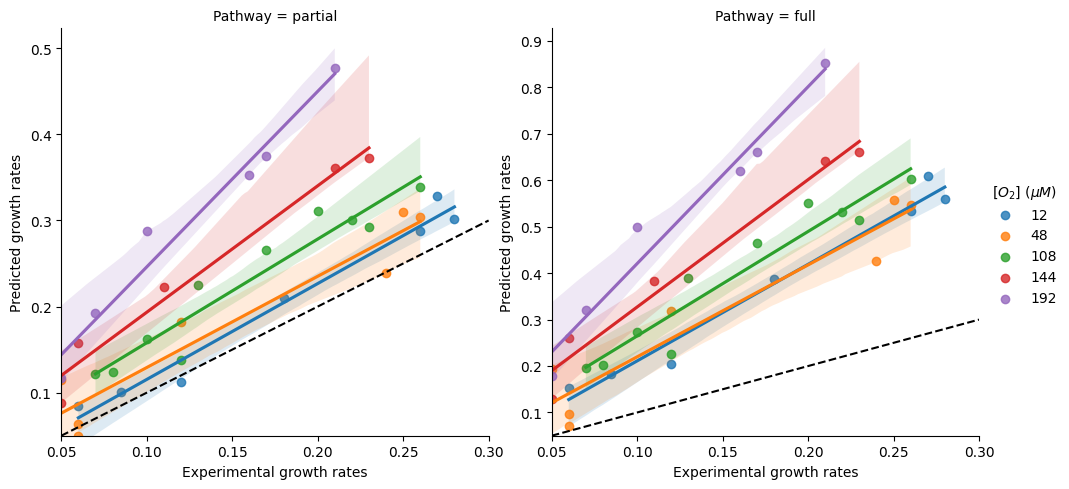

In [39]:
# Plot!
xbounds = [0.05, 0.3]
grid = sns.lmplot(o2_exp_vs_pred, x = 'Growth_rate_exp', y = 'Growth_rate', col = 'Pathway',
                  hue = 'O2_conc', palette = sns.color_palette("tab10"), facet_kws = { 'xlim': xbounds, 'sharey': None, 'sharex': True })
x = np.linspace(*xbounds, 10000)
grid.legend.set_title("$[O_2]$ ($\\mu M$)")
for ax in grid.axes.flat:
  ax.set_ylim([0.05, None])
  ax.set_xlabel('Experimental growth rates')
  ax.set_ylabel('Predicted growth rates')
  ax.plot(x, x, color='black', linestyle='--')